# Exercise 4

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 8)

from scipy import signal, stats
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
#import tensorflow.random as tf_r

from keras import Input, regularizers, initializers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report, accuracy_score

%run plot.py

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_importance

# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree, to_graphviz
from sklearn.metrics import mean_squared_error


import itertools

In [ ]:
tf.random.set_seed(12345)
np.random.seed(12345)


## Dataset generated for exercise 03 on convolutional neural networks (CNN)

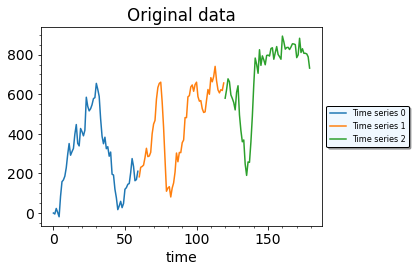

data:  10000


In [ ]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"Original data")

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
print('data: ',N)

# N and number of trainings for each value of N
N_list = [20, 50, 100, 150, 200, 250, 300, 400, 500]
n_trainings = 10

### Create dataframes to store the results

In [ ]:
# Accuracy
df_acc = pd.DataFrame(columns=['N', 'Training Accuracy CNN', 'Test Accuracy CNN', 'Training Accuracy XGB', 'Test Accuracy XGB'])

# Incremental std
df_std = pd.DataFrame(columns=['N', 'Training Accuracy CNN', 'Test Accuracy CNN', 'Training Accuracy XGB', 'Test Accuracy XGB'])

# Feature importance
df_tmp = pd.read_csv('feature_names.csv', sep='\t', header=None)
df_features = pd.DataFrame(columns=df_tmp.values)
df_features.insert(0, 'N', 0)

df_features.shape


(0, 500)

### Definitions

In [ ]:
def select_dataset(x, y, N, start):
    '''Select a chunk of the dataset and apply preprocessing to it (detrend)
    Input:
        x = data
        y = labels 
        N = size of the chunk
        start = starting point of the chunk
    Return:
        x_det = dataframe ready for the study
        y_sel = corresponding labels
    '''
    # Select N data samples
    x_sel = x[start:start+N]
    y_sel = y[start:start+N]        
     
    # Preprocessing 
    x_det = signal.detrend(x_sel)        # removes the tilt and centers the data
    x_det = x_det / np.std(x_det)

    return x_det, y_sel
 
def splitting_data(x, y, perc_train=0.8):
    '''Split data into validation (test) and training
    Input:
        x = selected data for training and testing
        y = corresponding labels 
        perc_training = percentage of training data
    Return:
        x_train, y_train, x_val, y_val
    '''
    # Splitting into training and validation

    N=len(x)
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    # N_val = len(x_val)
    # print(N_val)
    
    return x_train, y_train, x_val, y_val

# CNN study
def CNN_study(x_selected, y_selected, EPOCHS=100, BATCH_SIZE = 250):
    '''Define the CNN, train and test the model 
    Input:
        x_selected = selected data for training and testing
        y_selected = corresponding labels 
        EPOCHS = number of epochs
        BATCHSIZE = batch size
    Return:
        eval_train[1] = training accuracy
        eval_test[1] = test accuracy        
    '''
    
    x_train, y_train, x_val, y_val = splitting_data(x_selected, y_selected)

    # Convert y to an (N x n_class) matrix
    n_class = 3
    y_train = tf.keras.utils.to_categorical(y_train, n_class)
    y_val = tf.keras.utils.to_categorical(y_val, n_class)

    # Keras wants an additional dimension with a 1 at the end
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)

    # Regularizer and initializer 
    reg = regularizers.l2(0.02)# ridge with lambda
    ini = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)

    # Model
    NCONV = 1
    NF = 5 # number of filters

    model = Sequential()
    if NCONV == 1:
        model.add(Conv1D(filters=NF, kernel_size=11, kernel_initializer=ini,
                        kernel_regularizer=reg, activation = 'relu', 
                        input_shape=input_shape))

        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=NF, kernel_size=7,
                        activation='relu'))
        model.add(Flatten()) # To be sent to a normal neural network layer
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # Compile the model
    opt= tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])    


    # Fit the model
    fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0, shuffle=True)

    eval_train = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
    eval_test = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)
    
    
    return eval_train[1], eval_test[1]

def get_df(x):
    '''Build input dataframe for given data series, needed for XGBoost
    Input:
        var = array of time series, (#samples,time,1)
    Return:
        df = dataframe ready for features extraction
    '''
    
    # N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    # build id columns
    id_col = np.repeat(np.arange(N),t) # 000...t times...000, 111...t times...111, ... , NNN...t times...NNN
    # build time columns
    time_col = np.tile(np.arange(t),N) # 012...t, 012...t, repeat N times 
    # build var columns
    x_col = x.flatten()                # one sample of length t after the other
      
    # build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    # return dataframe
    return pd.DataFrame(x_dict)


def XGBoost_study(x_XGB, y_XGB, n_features=5):
    '''Extract features using tsfresh and train XGBClassifier
    Input:
        x_XGB = selected data for training and testing
        y_XGB = corresponding labels 
        n_features: number of features whose importance you want to return
    Return:
        acc_train = training accuracy
        acc_val = test accuracy    
        top_features = top features, dictionary
    '''

    # get df
    df = get_df(x_XGB) 

    # extract features
    x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores
    
    # remove columns with NaN or inf
    x_features.replace([np.inf, -np.inf], np.nan)
    x_features = x_features.dropna(axis='columns')

    # split data (x_features, by lines) into training and validation
    x_train, y_train, x_val, y_val = splitting_data(x_features, y_XGB) 
    # N_val = len(x_val)

    #rescale: in each feature, remove average and divide by std
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_val -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_val /= std
    
    # reproducibility
    np.random.seed(12345)

    #define parameters for xgboost
    params = {'max_depth':6,'min_child_weight':1,\
              'learning_rate':0.3,'use_label_encoder':False,
              'objective':'multi:softprob', 'eval_metric':'mlogloss'}
    # reg_lambda=0.001, n_estimators=10

    #build model with given params
    model = XGBClassifier(**params)

    #fit
    model.fit(x_train.values,y_train)
    
    #predict labels on training set
    y_pred_train = model.predict(x_train)
    #predict labels on validation set
    y_pred_val = model.predict(x_val)

    #compute accuracies
    acc_train = accuracy_score(y_train,y_pred_train) 
    acc_val = accuracy_score(y_val,y_pred_val)

    #get feature names
    feature_names = x_features.columns.values

    #empty dict
    feat_imp = {}
    #get f importance from model
    for i,f in enumerate(feature_names):
        feat_imp[f] = model.feature_importances_[i]
    #sort features depending on their importances
    #top_features =dict(itertools.islice(dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1])).items(), n_features))
    
    
    return acc_train, acc_val, feat_imp


# TEST:
# x_, y_ = select_dataset(x, y, 20, 50)
# train_acc, test_acc = CNN_study(x_, y_) 
# train_acc, test_acc = XGBoost_study(x_, y_) 


### a) Compare the accuracy of a CNN with that of an XGBoost model


We try the following values of $N$: $20, 50, 100, 150, 200, 250, 300, 400, 500$. For each value of $N$, we train both models on n_training $=10$ independent datasets. Finally, we show the mean and standard deviation of the accuracy obtained with both models for each value of $N$.

The XBG model is trained with the features extracted by tsfresh from same data, in the limit of small datasets.

#### Run this cell in local, automatically saves the results as pickle files

In [ ]:
on_deepnote = False

import warnings
warnings.filterwarnings('ignore')

if on_deepnote:
    import sys
    sys.exit("Fatal error! This cell must not be runned in deepnote!")

for N in N_list: 
    # start counting
    start=0
    i = 0
    
    while i<n_trainings:
        x_, y_ = select_dataset(x, y, N, start)

        print('\nTraining the CNN with N=%i, iteration number %i/10...' %(N, i+1))
        train_acc_CNN, test_acc_CNN = CNN_study(x_, y_) 

        print('\nTraining the XBG model with N=%i, iteration number %i/10...' %(N, i+1))
        train_acc_XGB, test_acc_XGB, all_features = XGBoost_study(x_, y_) 

        # df accuracy
        df_acc = pd.concat([df_acc, pd.DataFrame(data=[[N, train_acc_CNN, test_acc_CNN, train_acc_XGB, test_acc_XGB]], 
                                            columns=df_acc.columns)], ignore_index=True)

        # df std cumulative 
        if i > 0:
            df_std = pd.concat([df_std, df_acc.loc[df_acc['N'] == N].groupby('N', as_index=False).std()], ignore_index=True, axis=0)

        # df features
        tmp = {'N': N}
        all_features.update(tmp)
        df_features = df_features.append(all_features, ignore_index=True) 
        
        # update starting point and counter
        start += N
        i += 1

# save dataframes to file
df_acc.to_pickle("./HISTORY/accuracies.pkl")
df_features.to_pickle("./HISTORY/featuresimportance.pkl")
df_std.to_pickle("./HISTORY/incremental_std.pkl")


Training the CNN with N=20, iteration number 1/10...


2022-04-01 11:20:16.296618: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 11:20:16.297323: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.



Training the XBG model with N=20, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 29.52it/s]


[11:20:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 2/10...

Training the XBG model with N=20, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 34.09it/s]


[11:20:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 3/10...

Training the XBG model with N=20, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 32.80it/s]


[11:20:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 4/10...

Training the XBG model with N=20, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 29.78it/s]


[11:20:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 5/10...

Training the XBG model with N=20, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 27.76it/s]


[11:20:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 6/10...

Training the XBG model with N=20, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:01<00:00, 18.92it/s]


[11:20:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 7/10...

Training the XBG model with N=20, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 20.49it/s]


[11:20:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 8/10...

Training the XBG model with N=20, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 23.40it/s]


[11:20:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 9/10...

Training the XBG model with N=20, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 27.69it/s]


[11:20:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=20, iteration number 10/10...

Training the XBG model with N=20, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:00<00:00, 29.42it/s]


[11:20:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 1/10...

Training the XBG model with N=50, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:02<00:00,  5.91it/s]


[11:20:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 2/10...

Training the XBG model with N=50, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:03<00:00,  5.47it/s]


[11:21:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 3/10...

Training the XBG model with N=50, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:01<00:00,  8.69it/s]


[11:21:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 4/10...

Training the XBG model with N=50, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:01<00:00, 10.73it/s]


[11:21:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 5/10...

Training the XBG model with N=50, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:01<00:00, 10.77it/s]


[11:21:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 6/10...

Training the XBG model with N=50, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:01<00:00, 11.19it/s]


[11:21:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 7/10...

Training the XBG model with N=50, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:01<00:00,  9.05it/s]


[11:21:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 8/10...

Training the XBG model with N=50, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:01<00:00,  8.85it/s]


[11:21:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 9/10...

Training the XBG model with N=50, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:02<00:00,  8.13it/s]


[11:21:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=50, iteration number 10/10...

Training the XBG model with N=50, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 17/17 [00:01<00:00,  8.99it/s]


[11:21:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 1/10...

Training the XBG model with N=100, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:03<00:00,  5.03it/s]


[11:21:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 2/10...

Training the XBG model with N=100, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:06<00:00,  3.32it/s]


[11:21:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 3/10...

Training the XBG model with N=100, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:04<00:00,  4.12it/s]


[11:22:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 4/10...

Training the XBG model with N=100, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:03<00:00,  5.81it/s]


[11:22:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 5/10...

Training the XBG model with N=100, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:03<00:00,  6.25it/s]


[11:22:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 6/10...

Training the XBG model with N=100, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:03<00:00,  6.24it/s]


[11:22:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 7/10...

Training the XBG model with N=100, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:03<00:00,  5.46it/s]


[11:22:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 8/10...

Training the XBG model with N=100, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:03<00:00,  6.14it/s]


[11:22:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 9/10...

Training the XBG model with N=100, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:03<00:00,  5.84it/s]


[11:22:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=100, iteration number 10/10...

Training the XBG model with N=100, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:04<00:00,  4.96it/s]


[11:22:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 1/10...

Training the XBG model with N=150, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:05<00:00,  3.74it/s]


[11:23:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 2/10...

Training the XBG model with N=150, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:08<00:00,  2.17it/s]


[11:23:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 3/10...

Training the XBG model with N=150, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:06<00:00,  2.89it/s]


[11:23:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 4/10...

Training the XBG model with N=150, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:05<00:00,  3.23it/s]


[11:23:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 5/10...

Training the XBG model with N=150, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:04<00:00,  3.89it/s]


[11:23:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 6/10...

Training the XBG model with N=150, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:05<00:00,  3.69it/s]


[11:23:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 7/10...

Training the XBG model with N=150, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:06<00:00,  2.97it/s]


[11:24:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 8/10...

Training the XBG model with N=150, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:09<00:00,  2.11it/s]


[11:24:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 9/10...

Training the XBG model with N=150, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:06<00:00,  3.05it/s]


[11:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=150, iteration number 10/10...

Training the XBG model with N=150, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 19/19 [00:06<00:00,  2.85it/s]


[11:24:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 1/10...

Training the XBG model with N=200, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:07<00:00,  2.62it/s]


[11:24:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 2/10...

Training the XBG model with N=200, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:07<00:00,  2.53it/s]


[11:25:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 3/10...

Training the XBG model with N=200, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:08<00:00,  2.47it/s]


[11:25:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 4/10...

Training the XBG model with N=200, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:09<00:00,  2.20it/s]


[11:25:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 5/10...

Training the XBG model with N=200, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:09<00:00,  2.08it/s]


[11:25:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 6/10...

Training the XBG model with N=200, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:07<00:00,  2.55it/s]


[11:25:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 7/10...

Training the XBG model with N=200, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:09<00:00,  2.10it/s]


[11:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 8/10...

Training the XBG model with N=200, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:09<00:00,  2.18it/s]


[11:26:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 9/10...

Training the XBG model with N=200, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:06<00:00,  3.02it/s]


[11:26:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=200, iteration number 10/10...

Training the XBG model with N=200, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:08<00:00,  2.45it/s]


[11:26:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 1/10...

Training the XBG model with N=250, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:09<00:00,  2.13it/s]


[11:27:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 2/10...

Training the XBG model with N=250, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:09<00:00,  2.00it/s]


[11:27:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 3/10...

Training the XBG model with N=250, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:15<00:00,  1.26it/s]


[11:27:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 4/10...

Training the XBG model with N=250, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:13<00:00,  1.49it/s]


[11:27:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 5/10...

Training the XBG model with N=250, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:14<00:00,  1.37it/s]


[11:28:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 6/10...

Training the XBG model with N=250, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:09<00:00,  2.17it/s]


[11:28:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 7/10...

Training the XBG model with N=250, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:10<00:00,  1.91it/s]


[11:28:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 8/10...

Training the XBG model with N=250, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:11<00:00,  1.69it/s]


[11:29:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 9/10...

Training the XBG model with N=250, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:10<00:00,  1.95it/s]


[11:29:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=250, iteration number 10/10...

Training the XBG model with N=250, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:10<00:00,  2.00it/s]


[11:29:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 1/10...

Training the XBG model with N=300, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:10<00:00,  1.92it/s]


[11:29:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 2/10...

Training the XBG model with N=300, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:14<00:00,  1.42it/s]


[11:30:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 3/10...

Training the XBG model with N=300, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:15<00:00,  1.33it/s]


[11:30:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 4/10...

Training the XBG model with N=300, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:14<00:00,  1.38it/s]


[11:30:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 5/10...

Training the XBG model with N=300, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:11<00:00,  1.78it/s]


[11:31:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 6/10...

Training the XBG model with N=300, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:10<00:00,  1.89it/s]


[11:31:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 7/10...

Training the XBG model with N=300, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:14<00:00,  1.36it/s]


[11:31:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 8/10...

Training the XBG model with N=300, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:10<00:00,  1.88it/s]


[11:31:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 9/10...

Training the XBG model with N=300, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:16<00:00,  1.22it/s]


[11:32:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=300, iteration number 10/10...

Training the XBG model with N=300, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:18<00:00,  1.08it/s]


[11:32:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 1/10...

Training the XBG model with N=400, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:22<00:00,  1.10s/it]


[11:33:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 2/10...

Training the XBG model with N=400, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:18<00:00,  1.07it/s]


[11:33:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 3/10...

Training the XBG model with N=400, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:17<00:00,  1.13it/s]


[11:34:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 4/10...

Training the XBG model with N=400, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:20<00:00,  1.04s/it]


[11:34:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 5/10...

Training the XBG model with N=400, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:17<00:00,  1.16it/s]


[11:35:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 6/10...

Training the XBG model with N=400, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:18<00:00,  1.09it/s]


[11:35:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 7/10...

Training the XBG model with N=400, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:21<00:00,  1.05s/it]


[11:35:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 8/10...

Training the XBG model with N=400, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:22<00:00,  1.12s/it]


[11:36:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 9/10...

Training the XBG model with N=400, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:23<00:00,  1.16s/it]


[11:36:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=400, iteration number 10/10...

Training the XBG model with N=400, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:20<00:00,  1.04s/it]


[11:37:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 1/10...

Training the XBG model with N=500, iteration number 1/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:23<00:00,  1.20s/it]


[11:37:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 2/10...

Training the XBG model with N=500, iteration number 2/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:32<00:00,  1.61s/it]


[11:38:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 3/10...

Training the XBG model with N=500, iteration number 3/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:23<00:00,  1.18s/it]


[11:39:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 4/10...

Training the XBG model with N=500, iteration number 4/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:39<00:00,  1.99s/it]


[11:40:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 5/10...

Training the XBG model with N=500, iteration number 5/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:24<00:00,  1.23s/it]


[11:40:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 6/10...

Training the XBG model with N=500, iteration number 6/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:21<00:00,  1.09s/it]


[11:41:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 7/10...

Training the XBG model with N=500, iteration number 7/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:28<00:00,  1.42s/it]


[11:41:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 8/10...

Training the XBG model with N=500, iteration number 8/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:21<00:00,  1.08s/it]


[11:42:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 9/10...

Training the XBG model with N=500, iteration number 9/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:28<00:00,  1.45s/it]


[11:42:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Training the CNN with N=500, iteration number 10/10...

Training the XBG model with N=500, iteration number 10/10...


Feature Extraction: 100%|███████████████████████| 20/20 [00:16<00:00,  1.18it/s]


[11:43:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Import pickle files

In [ ]:
# load accuracy df
df_acc = pd.read_pickle('./HISTORY/accuracies.pkl')
print('Accuracy dataframe')
display(df_acc.head())

# load features df
df_features = pd.read_pickle('./HISTORY/featuresimportance.pkl')
df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.dropna(axis='columns')
df_features
print('\nFeatures importance dataframe')
display(df_features.head())

# load std df
df_std = pd.read_pickle("./HISTORY/incremental_std.pkl")
print('\nCumulative standard deviation during the 10 iterations, for each N')
display(df_std.head())

,N,Training Accuracy CNN,Test Accuracy CNN,Training Accuracy XGB,Test Accuracy XGB
0,20,0.8125,0.0,1.0,1.00
1,20,0.8750,0.0,1.0,0.75
2,20,0.8750,0.5,1.0,0.75
3,20,0.7500,0.0,1.0,1.00
4,20,0.8750,0.0,1.0,1.00


,N,"(value__variance_larger_than_standard_deviation,)","(value__has_duplicate_max,)","(value__has_duplicate_min,)","(value__has_duplicate,)","(value__sum_values,)","(value__abs_energy,)","(value__mean_abs_change,)","(value__mean_change,)","(value__mean_second_derivative_central,)",...,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation,value__variation_coefficient
0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,N,Training Accuracy CNN,Test Accuracy CNN,Training Accuracy XGB,Test Accuracy XGB
0,20,0.04419417,0.00000000,0.0,0.17677670
1,20,0.03608439,0.28867513,0.0,0.14433757
2,20,0.05983919,0.25000000,0.0,0.14433757
3,20,0.05590170,0.22360680,0.0,0.13693064
4,20,0.05229125,0.25819889,0.0,0.20412415
...,...,...,...,...,...
76,500,0.04538035,0.06853222,0.0,0.03141125
77,500,0.04149370,0.06264031,0.0,0.03132016
78,500,0.03889089,0.06266406,0.0,0.02927700
79,500,0.04234245,0.06892024,0.0,0.02818589


#### Mean and standard deviation of the accuracy for each value of N

In [ ]:
mean_acc = df_acc.groupby('N', as_index=False).mean()
std_acc = df_acc.groupby('N', as_index=False).std()

print('Mean accuracy for each value of N:')
display(mean_acc)

print('Standard deviation of the accuracies for each value of N:')
display(std_acc)


,N,Training Accuracy CNN,Test Accuracy CNN,Training Accuracy XGB,Test Accuracy XGB
0,20,0.83125000,0.22500000,1.0,0.75000000
1,50,0.73000000,0.41000001,1.0,0.93000000
2,100,0.63000000,0.49000000,1.0,0.92000000
3,150,0.70500000,0.54000001,1.0,0.93666667
4,200,0.71000000,0.60249999,1.0,0.90750000
5,250,0.68299999,0.62600001,1.0,0.93200000
6,300,0.67333333,0.62500000,1.0,0.93166667
7,400,0.80093750,0.73125001,1.0,0.93750000
8,500,0.86650000,0.84200001,1.0,0.93800000


,N,Training Accuracy CNN,Test Accuracy CNN,Training Accuracy XGB,Test Accuracy XGB
0,20,0.09340213,0.21889876,0.0,0.26352314
1,50,0.06749486,0.11972189,0.0,0.08232726
2,100,0.06185780,0.17448337,0.0,0.04216370
3,150,0.05431959,0.08999314,0.0,0.05317105
4,200,0.05544956,0.07115125,0.0,0.03545341
5,250,0.06634087,0.06603030,0.0,0.04638007
6,300,0.05955078,0.08507441,0.0,0.03088209
7,400,0.06086488,0.06928454,0.0,0.02946278
8,500,0.04215053,0.07052186,0.0,0.02658320


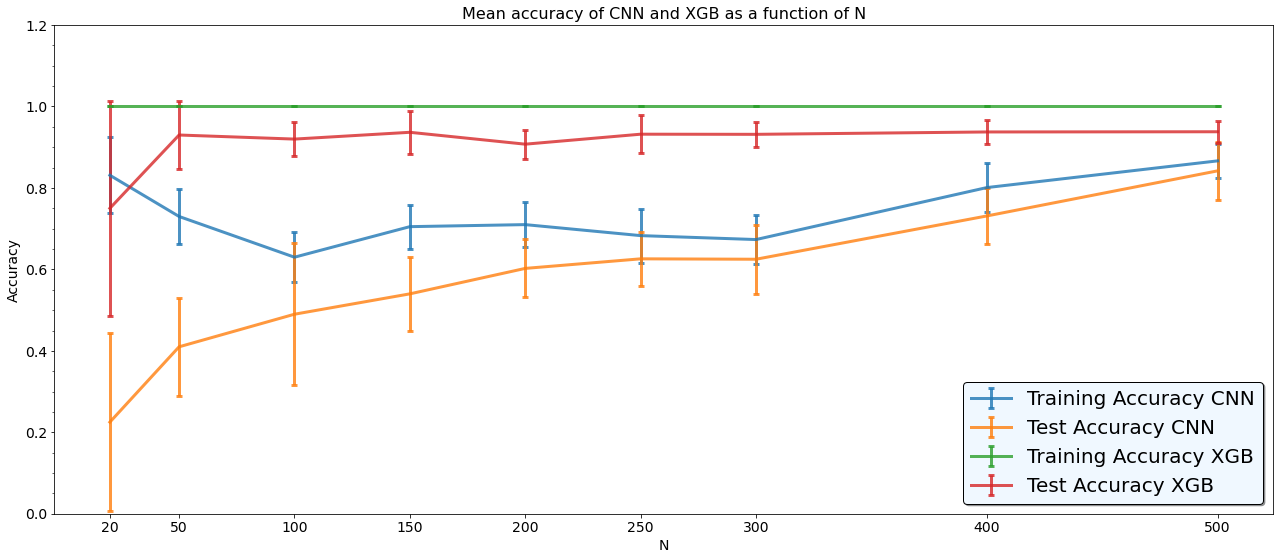

In [ ]:
# plot of the accuracy means/stds vs N

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.errorbar(N_list, mean_acc['Training Accuracy CNN'], yerr=std_acc['Training Accuracy CNN'],
            label='Training Accuracy CNN', color='C0', lw=3, alpha=0.8, capsize=3, capthick=3)
ax.errorbar(N_list, mean_acc['Test Accuracy CNN'], yerr=std_acc['Test Accuracy CNN'],
            label='Test Accuracy CNN', color='C1', lw=3, alpha=0.8, capsize=3, capthick=3)

ax.errorbar(N_list, mean_acc['Training Accuracy XGB'], yerr=std_acc['Training Accuracy XGB'],
            label='Training Accuracy XGB', color='C2', lw=3, alpha=0.8, capsize=3, capthick=3)
ax.errorbar(N_list, mean_acc['Test Accuracy XGB'], yerr=std_acc['Test Accuracy XGB'],
            label='Test Accuracy XGB', color='C3', lw=3, alpha=0.8, capsize=3, capthick=3)

ax.set_xlabel('N', fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_title("Mean accuracy of CNN and XGB as a function of N", fontsize=24)
ax.set_ylim(top=1.1, bottom=-0.1)

ax.set_xticks(ticks=N_list)

ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)

ax.grid()

# ax1.plot(N_list, std_acc['Training Accuracy CNN'], label='Training Accuracy CNN', color='C0', lw=3, alpha=0.8)
# ax1.plot(N_list, std_acc['Test Accuracy CNN'], label='Test Accuracy CNN', color='C1', lw=3, alpha=0.8)
# 
# ax1.plot(N_list, std_acc['Training Accuracy XGB'], label='Training Accuracy XGB', color='C2', lw=3, alpha=0.8)
# ax1.plot(N_list, std_acc['Test Accuracy XGB'], label='Test Accuracy XGB', color='C3', lw=3, alpha=0.8)
# 
# ax1.set_xlabel('N', fontsize=18)
# ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_title("Stardard deviation of the accuracy of CNN and XGB as a function of N", fontsize=18)
# ax1.set_ylim(top=1.0, bottom=-0.05)
# ax1.minorticks_on()

ax.legend(loc='lower right', #bbox_to_anchor=(1, 0.5), 
    fontsize=20, prop={'size':20}, facecolor='aliceblue', edgecolor='black', shadow=True
    )

fig.tight_layout()
plt.show()



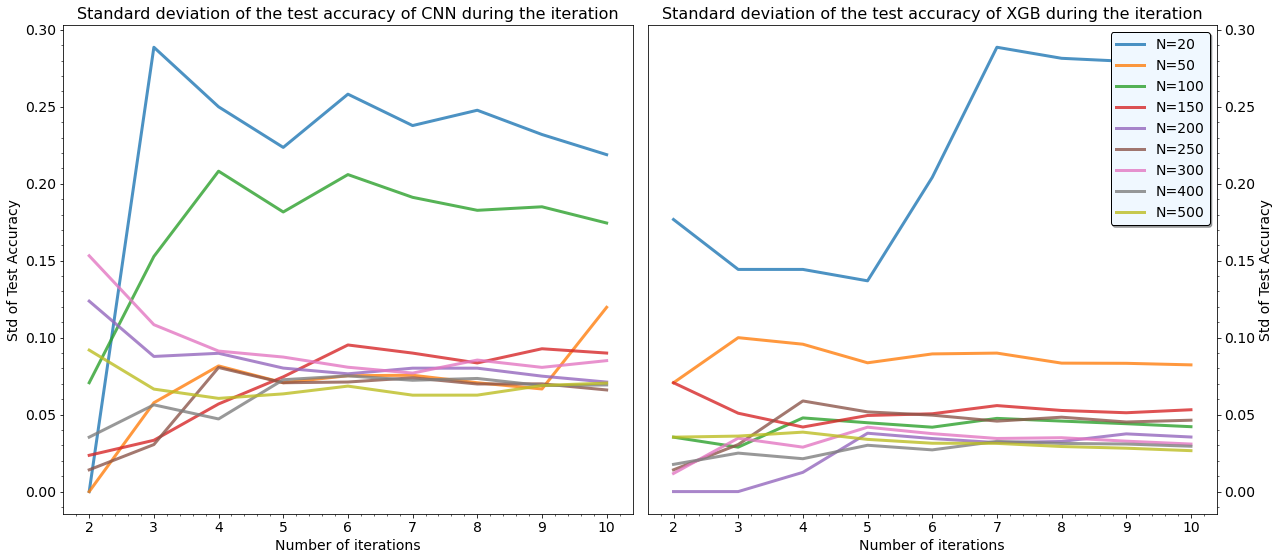

In [ ]:
# std behavior as a function of the iterations, for different N

fig, AX = plt.subplots(1, 2, figsize=(18, 8))
x_plot = np.arange(2, n_trainings+1)

for i,N in zip(range(len(N_list)), N_list):
    AX[0].plot(x_plot, df_std.loc[df_std['N'] == N]['Test Accuracy CNN'], label='N='+str(N), color='C'+str(i), lw=3, alpha=0.8)
    AX[1].plot(x_plot, df_std.loc[df_std['N'] == N]['Test Accuracy XGB'], label='N='+str(N), color='C'+str(i), lw=3, alpha=0.8)
    
for ax, modell in zip(AX, ['CNN', 'XGB']):
    ax.set_xlabel('Number of iterations', fontsize=20)
    ax.set_ylabel("Std of Test Accuracy", fontsize=20)
    ax.set_title("Std of the test accuracy of " + modell + " during the iteration", fontsize=24)
    ax.minorticks_on()

AX[1].yaxis.tick_right()
AX[1].yaxis.set_label_position("right")
AX[1].legend( 
    loc='center left', bbox_to_anchor=(1, 0.5)
    fontsize=14, prop={'size':16}, facecolor='aliceblue', edgecolor='black', shadow=True
    )

fig.tight_layout()





### b) Most relevant features
For task a) we have seen during the lesson that XGBoost finds some features more relevant than others. Find the description of those features in the documentation and try to provide an explanation of why they are relevant for that problem.

In [ ]:
mean_imp = (df_features.groupby('N', as_index=False).mean()).mean()[1:].sort_values(ascending=False)
display(mean_imp.head(10))

print('Total importance of the first 20 features:', round(sum(np.array(mean_imp.head(20))), 5))

value__c3__lag_1                                                     0.12270311
value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"     0.07224468
value__cid_ce__normalize_False                                       0.06482934
value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0     0.03072249
value__absolute_maximum                                              0.02146251
value__abs_energy                                                    0.01945939
value__skewness                                                      0.01857079
value__c3__lag_2                                                     0.01620625
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0    0.01572647
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0    0.01537178
dtype: float64

Total importance of the first 20 features 0.5178781641419946


- `c3__lag_1`: c3 statistics is used to measure non linearity in the time series; lag it is a parameter used to calculate the value of the feature c3.
It might have a high importance because the time series are represented by a sin function, that has a marked non-linearity. The latter should vary between time serieses with different labels being the sine inserted differrently.
                                                
- `linear_trend_chunk_len_5` : Calculates a linear least-squares regression for values of the time series that were aggregated over chunks versus the sequence from 0 up to the number of chunks minus one. The chunksize is regulated by “chunk_len”, in this case 5. It specifies how many time series values are in each chunk.

Its importance might derive from the fact that, although sin is not a linear function, for small values of x (and periodically) it behaves like x. So when we divide it in chuncks this behaviour could arise.
Adding once the peak of the sine and the once the valley on different spots, the linear function of the chunks shifts from x to -x.

- `cid_ce__normalize_False` : This function calculator is an estimate for a time series complexity (A more complex time series has more peaks, valleys etc.).  Normalize equal to False represents that the signal has discrete values and during the analysis it is not trasformed towards a complex frequency-domain representation.

As the description says, this parameters highly carachterizes a function like the sine function that has multiple maxima and minima, positioned on multiple spots for different time serieses.


- `change_quantiles__agg_"var"__isabs_True__qh_1.0__ql_0.0` : First fixes a corridor given by the quantiles ql and qh of the distribution of the data x. Then calculates the average, absolute value of consecutive changes of the time series x inside this corridor.
Think about selecting a corridor on the y-Axis and only calculating the mean of the absolute change of the time series inside this corridor.

Being the function periodic, this may imply a higher importance of this feature given that in the corridors chosen the mean of the absolute change does not vary too much troughout the series.


- `absolute_maximum` : This feature calculates the highest absolute value of the time series x. 

Being the data generated as a sine with noise, the maximum of the function should fall around similar values for each time series.                       


- `abs_energy` : It returns the absolute energy of the time series which is the sum over the squared values.           


- `skewness` : Returns the sample skewness of x (calculated with the adjusted Fisher-Pearson standardized moment coefficient G1).     


- `c3__lag_2`  : c3 statistics is used to measure non linearity in the time series, this time with a lag parameter equal to 2.

As lag_1 case


- `change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0`: analysis on other corridors due to different values of qh and ql. 


- `change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0` : analysis on other corridors due to different values of qh and ql.


### c) XGBoost vs FFNN with tsfresh
With the features extracted by tsfresh, train a standard (non-convolutional) feed forward neural network (FFNN) and compare the performances with those of XGBoost. Than keep only the most relevant features from XGBoost and train another FFNN with this smaller set. Is the new FFNN working better than the one trained with all features?

#### Preprocessing

In [ ]:
# select 400 time series
x_, y_ = select_dataset(x, y, 400, 0)

# get df
df = get_df(x_) 

# extract features
x_features = extract_features(
                        df, #our dataframe
                        column_id='id', #sample id, from 0 to N
                        column_sort='time', #timestep, from 0 to t
                        column_kind=None, #we have only one feature
                        column_value='value', #value of input 
                        n_jobs=4) #number of cores

# remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

# split data (x_features, by lines) into training and validation
x_train, y_train, x_val, y_val = splitting_data(x_features, y_) 

# rescale: in each feature, remove average and divide by std
average = np.mean(x_train,axis=0)
x_train -= average
x_val -= average

std = np.std(x_train,axis=0)
x_train /= std
x_val /= std

# get feature names
feature_names = x_features.columns.values

Feature Extraction: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


#### XGBoost Training

In [ ]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False,
          'objective':'multi:softprob', 'eval_metric':'mlogloss'}

#build model with given params
model_XGB = XGBClassifier(**params)
#fit
model_XGB.fit(x_train.values,y_train)

#predict labels on training set
y_pred_train = model_XGB.predict(x_train)

#predict labels on validation set
y_pred_val = model_XGB.predict(x_val)

#compute accuracies
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_val,y_pred_val)

#get feature importances
feat_imp = {}
for i,f in enumerate(feature_names):
    feat_imp[f] = model_XGB.feature_importances_[i]
    

In [ ]:
print('Training accuracy: %.4f' % acc_train)
print('Test accuracy: %.4f' % acc_val)

Training accuracy: 1.0000
Test accuracy: 0.9625


#### XGB results

num_trees= 300


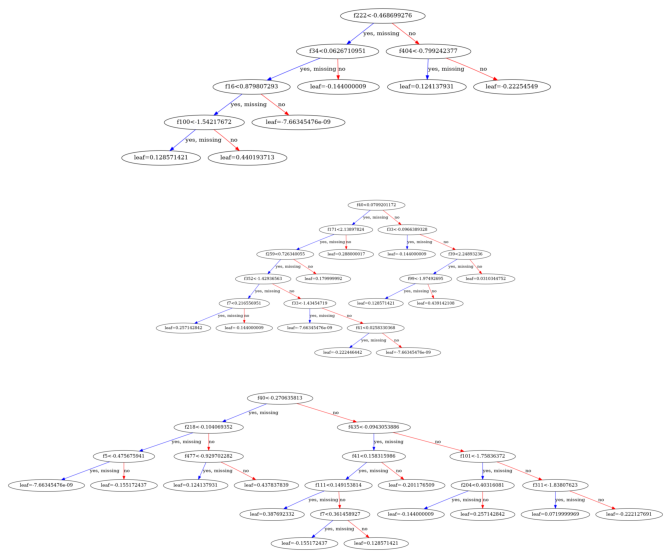

In [ ]:
# TREES

dump_list = model_XGB.get_booster().get_dump()
num_trees = len(dump_list)
print("num_trees=",num_trees)

fig, AX = plt.subplots(3,1,figsize=(30, 10))
for i in range(3):
    ax=AX[i]
    plot_tree(model_XGB, num_trees=i, ax=ax)

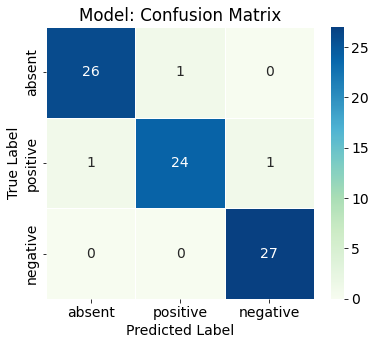

In [ ]:
# CONFUSION MATRIX

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

show_confusion_matrix(y_val, y_pred_val)

Top 10 features:



0    (value__change_quantiles__f_agg_"var"__isabs_F...
1    (value__agg_linear_trend__attr_"intercept"__ch...
2                       (value__c3__lag_1, 0.08402595)
3                      (value__c3__lag_2, 0.057369277)
4    (value__cwt_coefficients__coeff_10__w_2__width...
5    (value__partial_autocorrelation__lag_6, 0.0340...
6    (value__change_quantiles__f_agg_"var"__isabs_T...
7    (value__change_quantiles__f_agg_"var"__isabs_F...
8    (value__change_quantiles__f_agg_"mean"__isabs_...
9    (value__change_quantiles__f_agg_"var"__isabs_F...
dtype: object

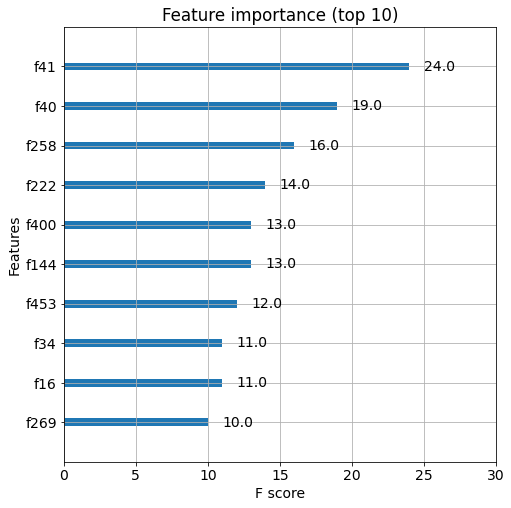

In [ ]:
# FEATURES IMPORTANCE
print('Top 10 features:\n')
top_features = (itertools.islice(dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1])).items(), n_features))
display(pd.Series(top_features).head(10))


# plot
fig, ax=plt.subplots(figsize=(12, 8))
plot_importance(model_XGB, ax=plt.gca(), title='Feature importance (top 10)', max_num_features=10, 
                importance_type='weight', xlim=(0,30))
                # ”weight” is the number of times a feature appears in a tree

fig.subplots_adjust(left=0.4)  



#### Feed forward neural network (FFNN)

In [ ]:
# switching to one-hot encoding
n_class = 3
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_val = tf.keras.utils.to_categorical(y_val, n_class)

# # Keras wants an additional dimension with a 1 at the end
# x_train = x_train.reshape(x_train.shape[0], L, 1)
# x_val =  x_val.reshape(x_val.shape[0], L, 1)
# input_shape = (L, 1)
    
# reproducibility
np.random.seed(12345)
tf.random.set_seed(12345)


#### Model definition

In [ ]:
n_features = x_features.shape[1]
print(n_features)

506


#### Compile and train the model

In [ ]:
# model for the FFNN architecture
from keras.regularizers import l2

def choosed_model():
    model=Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    # model.add(Dropout(0.1))
    model.add(Dense(n_class, activation='softmax'))
    return model

model_FFNN = choosed_model()
nepoch=200
batch_size=5

    
model_FFNN.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 20)                10140     
                                                                 
 dense_111 (Dense)           (None, 20)                420       
                                                                 
 dense_112 (Dense)           (None, 20)                420       
                                                                 
 dense_113 (Dense)           (None, 20)                420       
                                                                 
 dense_114 (Dense)           (None, 3)                 63        
                                                                 
Total params: 11,463
Trainable params: 11,463
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow.keras.optimizers as opt
optimizer=opt.Adam(learning_rate=0.01)

model_FFNN.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer=optimizer, 
                metrics=['accuracy'],
                )

fit = model_FFNN.fit(x_train, y_train, 
                epochs = nepoch, batch_size=batch_size, 
                validation_data=(x_val, y_val), 
                verbose=0)



#### FFNN results

In [ ]:
# let's compute again the metrics as previously they were affected by dropout
b, ACC_train = model_FFNN.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)
a, ACC_test = model_FFNN.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)

print(a, b)

print('Training accuracy: %.4f' % ACC_train)
print('Test accuracy: %.4f' % ACC_test)

nan nan
Training accuracy: 0.3344
Test accuracy: 0.3375


## Search for a simple and effective model for the classification of two dimensional data
Try different parameters (gamma, lambda, n_estimators, …), aiming to find the simplest yet effective XGBoost
model that keeps a good accuracy.

In [ ]:
CASE = 1

S = 2
N = 2000
N_train = 1000
N_test  = N - N_train
x_1 = S*(2*np.random.rand(N,2)-1)
y_1 = np.zeros(N).astype(int)

for n in range(N):
    if CASE==1:
        if x_1[n,1]<-0.6 and x_1[n,0]>-0.2: y_1[n]=1
        if x_1[n,1]>0.4 and x_1[n,0]<-0.8: y_1[n]=1
        if x_1[n,1]>1.0 and x_1[n,0]>0.8: y_1[n]=1
    elif CASE==2:
        if x_1[n,1]<0 and x_1[n,0]>0.5: y_1[n]=1
        if x_1[n,1]>0 and np.sqrt((x_1[n,0]+0.3)**2+x_1[n,1]**2)<1.5: y_1[n]=1

# random permutations of data
perm = np.random.permutation(N)
x_1 = x_1[perm]
y_1 = y_1[perm]

x_train_1,y_train_1 = x_1[:N_train],y_1[:N_train]
x_test_1,y_test_1 = x_1[N_train:],y_1[N_train:]

In [ ]:
# Hyper-parameters
def_params ={'seed':1, 'use_label_encoder':False,
             'objective':'binary:logistic', 'eval_metric':'logloss'}
param_list ={'max_depth':[4, 6, 8],
             'gamma':[1, 10, 100],
             'min_child_weight':[int(N*0.01), int(N*0.03), int(N*0.05), int(N*0.1)],
             'n_estimators':[10, 20, 30],
             'reg_lambda':[1,10,100,1000]}

model_gridsearch = XGBClassifier(**def_params)


# perform gridsearch
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_list, n_jobs=1, cv=4)
grid_result = grid.fit(x_train_1,y_train_1)


# summarize results
results_df = pd.DataFrame(grid.cv_results_).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
display(results_df.loc[:20,["param_"+k for k in param_list.keys()]+["mean_test_score","rank_test_score"]])

print("\n\nBest parameters set found:")
display(pd.DataFrame(grid_result.best_params_, index=[0]))
print("\nScore with best parameters:")
print(grid_result.best_score_.round(8))

,param_max_depth,param_gamma,param_min_child_weight,param_n_estimators,param_reg_lambda,mean_test_score,rank_test_score
0,4,1,20,10,1,0.992,1
1,6,1,20,10,1,0.992,1
2,8,1,20,10,1,0.992,1
3,6,1,20,20,1,0.991,4
4,4,1,20,20,1,0.991,4
5,8,1,20,30,1,0.991,4
6,8,1,20,20,1,0.991,4
7,4,1,20,30,1,0.991,4
8,6,1,20,30,1,0.991,4
9,6,10,20,20,1,0.990,10




Best parameters set found:


,gamma,max_depth,min_child_weight,n_estimators,reg_lambda
0,1,4,20,10,1



Score with best parameters:
0.992


From the grid search it is possible to find a simple model with accuracy of **99.2%**. This simple model is a compromise between a simple model with poor accuracy and a complex model with accuracy of 99.8%. In the grid search the parameters that lead to a largest gain in accuracy are, in descending order, the minimum number of samples in each leaf (`min_child_weight`), the minimum improvement in the loss function at each iteration (`gamma`), the number of estimators (`n_estimators`). The parameters `reg_lambda` and `max_depth` have a minor role in the minimization.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c8e8699-579b-4f24-9413-a98afebf04a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>